### 4. Aufgabe - Communities

In [85]:
from src.Graph import Graph
import src.communities.bron_kerbosch as bk
import src.communities.two_plexe as tp
import src.graphParameters as gp
from src.printGraph import draw_graph

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import networkx as nx

### Maximale Cliquen 
Implementierung der verschiedenen Versionen des bron-kerbosch-Algorithmen:
#### regulär
> Iteriere über alle Knoten, rekursives Finden der zugehörigen maximalen Cliquen
#### pivot
> Ähnlich, aber Ersparen von "unnötiger" Arbeit: \
> einige nicht zielführende K, F, C Zuordnungen werden nicht untersucht
* pivot durch brute-force minimieren von |C/(PivotNachbarn)|
* pivot durch heuristisches minimieren: Pivot mit maximalem Grad in G
#### nach degeneracy-ordering
> limitieren der Rekursionstiefe durch feste maximale Anzahl der vorwärts-Nachbarn \
> zusätzlich Nutzen der Pivot-Strategien


 ### Vergleich der verschiedenen Algorithmen

 * orange: Pivot durch brute force
 * blau: Pivot durch max Grad
 * irrelevant für standard bron-kerbosch (regular)

 <img src="presentation/compare_bronkerbosch_algos.png" />

In [125]:
from time import time
import os
import pandas as pd

directory = "networks/econ_networks/"
#directory = "networks/"

def graph_stats_df(directory):
    df = pd.DataFrame(columns=["filename","nodes","edges","density", "degen"])
    for filename in os.listdir(directory):
        if os.path.isdir(directory+filename):
            continue
        filepath = directory + filename
        name = filepath.split("/")[-1]
        try:
            G = Graph(filepath)
        except:
            try:
                G = Graph(filepath,mode="metis")
            except:
                continue

        dens_G = round(gp.density(G),3)
        degen_G,_ = gp.degeneracy_bucket(G)
        stats = [name,G.n,G.m,dens_G, degen_G, ]
        df.loc[len(df)] = stats
    return df


def bron_kerbosh_results_df(filepath):
    versions = [("regular",None), ("pivot", "brute force"), ("pivot", "degree"), ("degeneracy", "brute force"),("degeneracy", "degree")]
    df =pd.DataFrame(columns=["version","num_cliques", "time","finished"])
    timeout = 30

    try:
        G = Graph(filepath)
    except:
        try:
            G = Graph(filepath,mode="metis")
        except:
            return

    for v in versions:
        mode, pivot_strategy = v
        cliques = []

        tik = time()
        finished = True
        for i, clique in enumerate(bk.find_cliques(G, mode = mode, pivot_strategy=pivot_strategy, timeout_regular = timeout)):
            if isinstance(clique, Exception):
                finished = False
            if i % 1000 == 0:
                t = time()-tik
                if t>timeout:
                    finished = False
                    break
            cliques.append(clique)
        t = time()-tik
        stats = [f"{mode} {pivot_strategy}", len(cliques),round(t,3),finished]
        df.loc[len(df)] = stats
    return df

### Grenzen
* meisten Graphen in aus "economic networks" können nicht in angemessener Zeit berechnet werden
* Abbruch nach 30 Sekunden
* unterschiede der Verschiedenen Versionen der Algorithmen: Anzahl gefundener Cliquen in 30 Sekunden

In [149]:
stats_df = graph_stats_df(directory)
stats_df

,filename,nodes,edges,density,degen
0,econ-beacxc.mtx,493,42176,0.348,118
1,econ-beaflw.mtx,502,44900,0.357,122
2,econ-beause.mtx,507,39428,0.307,106
3,econ-mahindas.mtx,1258,7513,0.010,40
4,econ-orani678.mtx,2529,86768,0.027,192
5,econ-psmigr1.mtx,3140,410781,0.083,250
6,econ-wm1.mtx,258,2389,0.072,33


In [152]:
algo_results_df = bron_kerbosh_results_df("networks/econ_networks/econ-beacxc.mtx")
algo_results_df
# Warning: Runtime about 2 minutes

,version,num_cliques,time,finished
0,regular None,68,30.004,False
1,pivot brute force,161000,30.090,False
2,pivot degree,53000,30.305,False
3,degeneracy brute force,179000,30.036,False
4,degeneracy degree,48000,30.417,False


* regulärer Bron-Kerbosch algorithmus bleibt oft bei relativ wenigen gefundenen Cliquen hängen \
    wahrscheinlich wegen hoher rekursionstiefe
* leichte Unterschiede zwischen Algorithmen die pivot durch brute force und durch max degree berechnen \
    (brute force etwas besser)


### Anzahl maximale Cliquen vs. theoretische Worst Case Anzahl
* wesentlich geringer

### größte maximale Clique vs. größter 2-Plex 

In [147]:

def graph_stats_with_cliques_df(directory):
    df = pd.DataFrame(columns=["filename","nodes","edges","density", "degen", "max_cliques", "max_cl_size", "max_tp_size", "theo_max_cl"])
    for filename in os.listdir(directory):
        if os.path.isdir(directory+filename):
            continue
        filepath = directory + filename
        name = filepath.split("/")[-1]
        try:
            G = Graph(filepath)
        except:
            try:
                G = Graph(filepath,mode="metis")
            except:
                continue

        dens_G = round(gp.density(G),3)
        degen_G,_ = gp.degeneracy_bucket(G)
        dens_G = round(gp.density(G),3)
        max_cliques = list(bk.find_cliques(G,"pivot", "brute force"))
        largest_max_cl = 0
        for cl in max_cliques:
            if len(cl)>largest_max_cl:
                largest_max_cl=len(cl)
#        two_plex = tp.search_2_plex(G)
        two_plex = 0
        theo_max = G.n * 3**((gp.max_degree(G)+1)/3)
        stats = [name,G.n,G.m,dens_G, degen_G, len(max_cliques), largest_max_cl, two_plex, theo_max]
        df.loc[len(df)] = stats
    return df
df = graph_stats_with_cliques_df("networks/")
df

,filename,nodes,edges,density,degen,max_cliques,max_cl_size,max_tp_size,theo_max_cl
0,bio-celegans.mtx,453,2025,0.020,10,668,9,0,3.218976e+40
1,bio-dmela.mtx,7393,25569,0.001,11,23545,7,0,1.760113e+34
2,out.adjnoun_adjacency_adjacency_,112,425,0.068,6,303,5,0,1.002857e+10
3,out.moreno_zebra_zebra_,27,111,0.316,11,19,10,0,6.561000e+03
4,out.ucidata-zachary_,34,78,0.139,4,36,5,0,2.478600e+04
5,coAuthorsCiteseer.graph,227320,814134,0.000,86,145904,87,0,5.237595e+223
6,special_case_for_networkx.mtx,12,15,0.227,2,11,3,0,1.080000e+02


In [97]:
import networkx as nx
def draw_gexf_community(file, calc_comm):
    nxG = nx.read_gexf(file)
    nxG = nx.relabel_gexf_graph(nxG)
    G = Graph()
    for n in nxG.nodes():
        n = n.replace(" ","_")
        G.add_node(n)
    for e1, e2 in nxG.edges():
        e1 = e1.replace(" ", "_")
        e2 = e2.replace(" ", "_")
        G.add_edge(e1,e2)

    comm = calc_comm(G)

    print(comm)
    color_map = ["orange" if n.replace(" ","_") in comm else "green" for n in nxG]

    # 1114, 833, 1997, 764,  947, 164
    seed = random.randint(1,2000)
    print(seed)

    my_pos = nx.spring_layout(nxG, seed = 1104)
    plt.figure(figsize=(12,12))
    nx.draw(nxG, pos = my_pos, node_color= color_map,with_labels=True, node_size=500, edge_color='black', linewidths=1, font_size=8)
    plt.show()

### Maximale Cliquen / Two-Plexe in realen Anwendungsgebieten

{'FEYD', 'REVEREND_MOTHER', 'CHANI', 'GURNEY', 'PAUL', 'ALIA', 'EMPEROR', 'JESSICA'}
1390


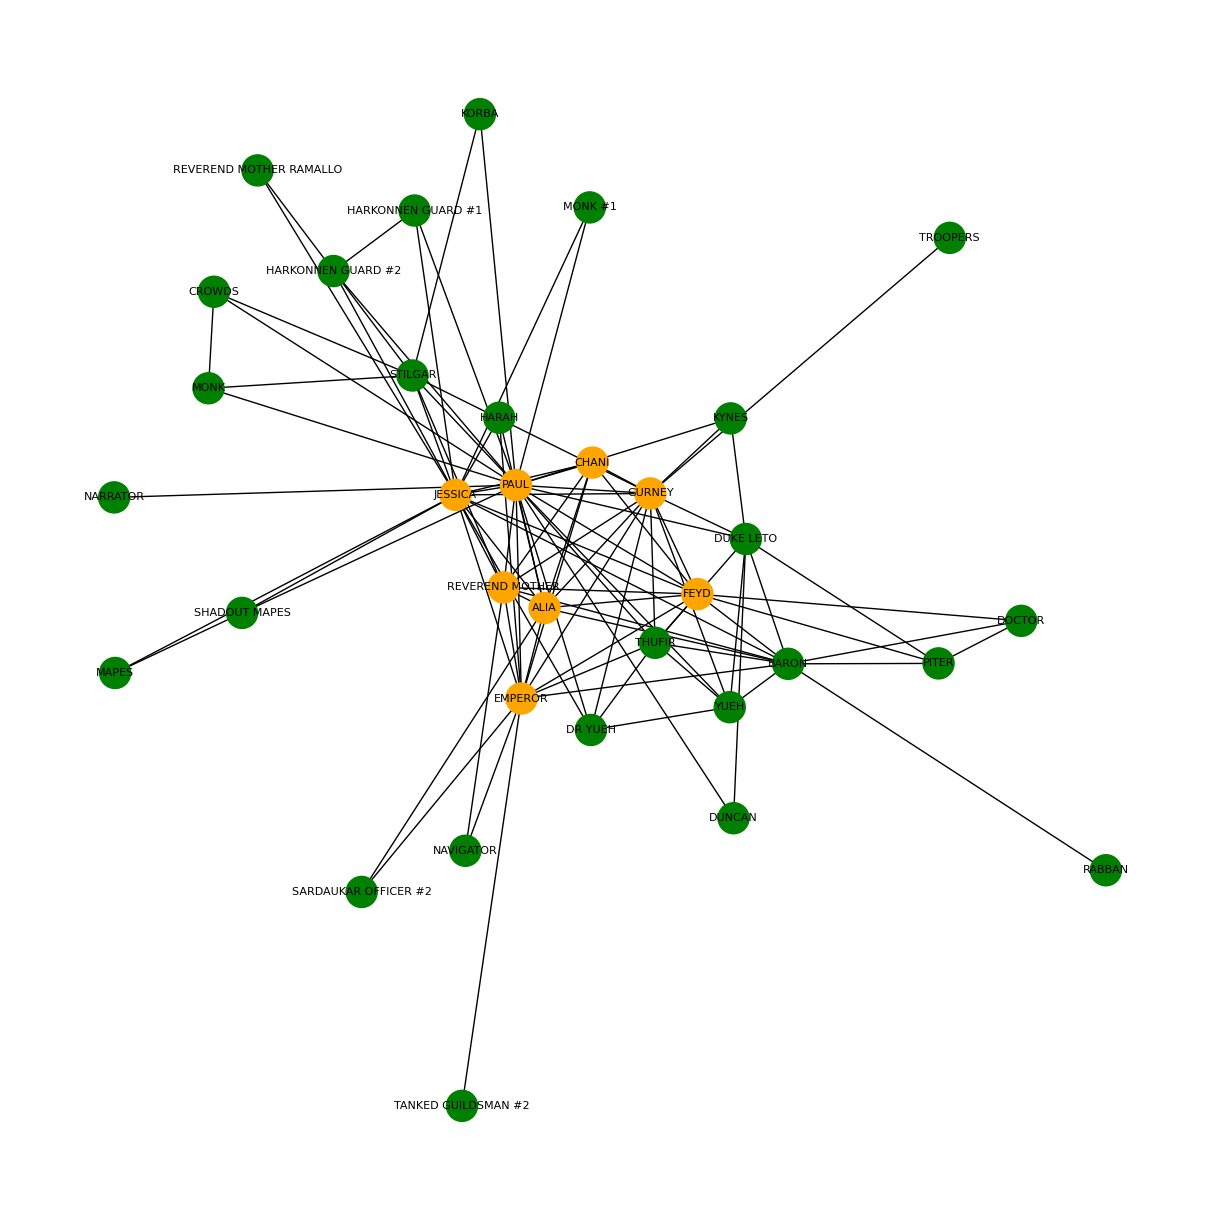

In [98]:
def largest_max_clique(G):
    max_clique = [max(list(bk.find_cliques(G)))]
    for c in bk.find_cliques(G):
        if len(c)>len(max_clique):
            max_clique = c
    return max_clique

draw_gexf_community("networks/Dune.gexf", largest_max_clique)

{'VINCENT', 'BUTCH', 'ROGER', 'BRETT', 'JULES', 'MARSELLUS', 'MARVIN'}
1197


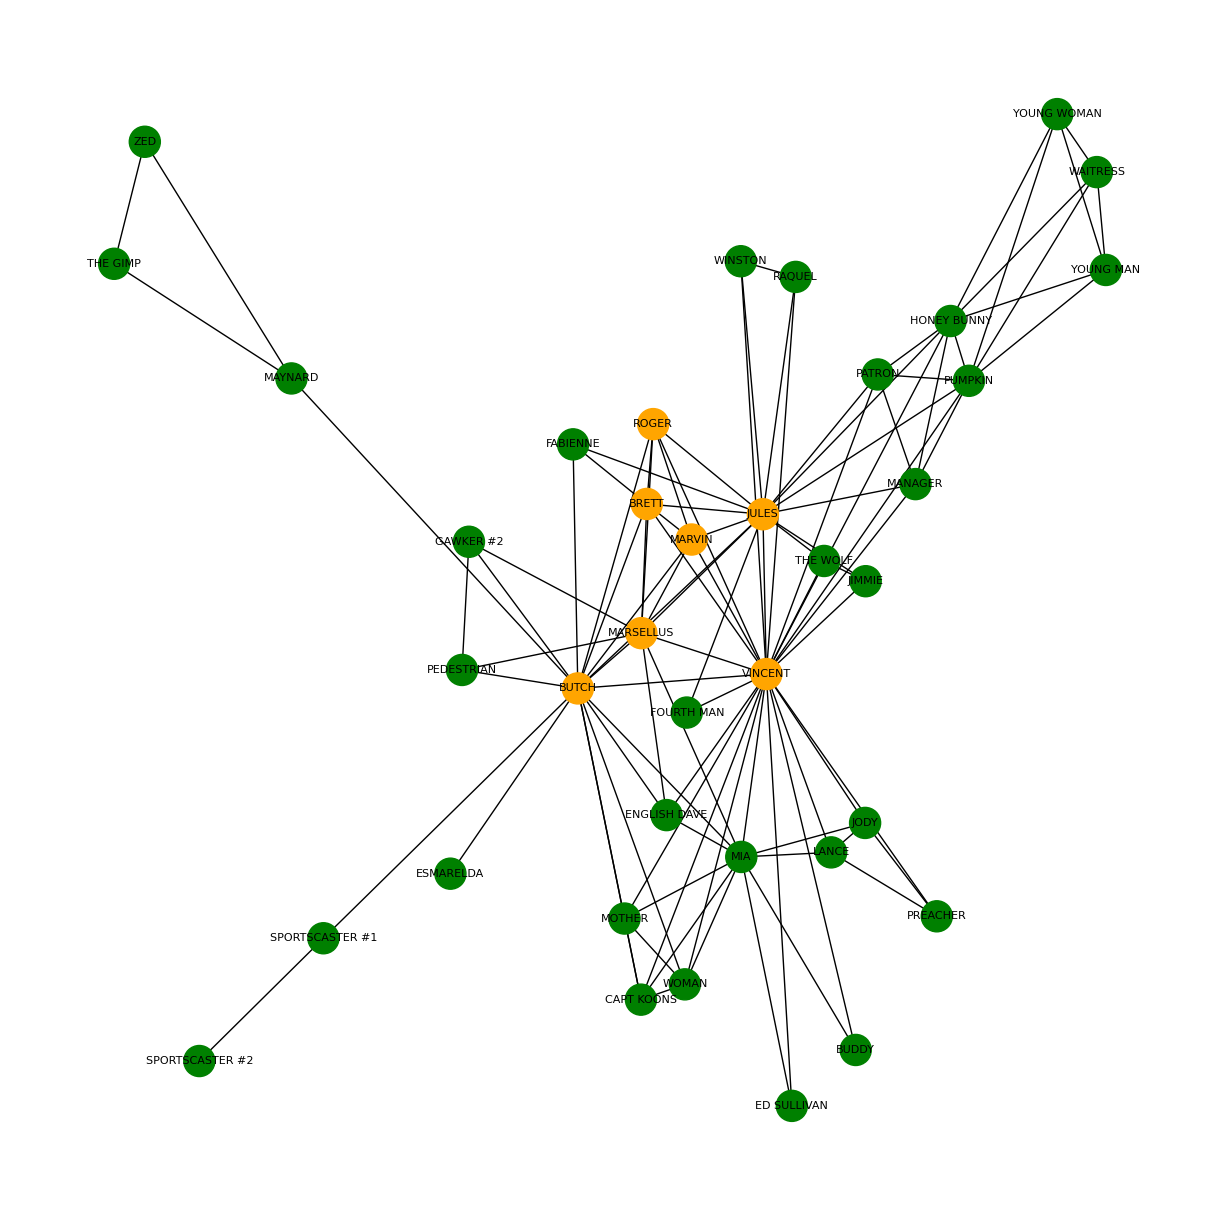

In [100]:
draw_gexf_community("networks/pulpfiction.gexf", largest_max_clique)